In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import statsmodels.api as sm
import scipy.stats
import seaborn as sns
from math import sqrt

pd.set_option('mode.chained_assignment', None)
sns.set_style("whitegrid")

# Read the dataset
file_network = pd.read_csv("data/london_flows.csv")
file_network = file_network[file_network.distance != 0]
file_network = file_network[file_network.jobs != 0]
file_network = file_network[file_network.population != 0]

# Utility functions
def CalcRSquared(observed, estimated):
    r, _ = scipy.stats.pearsonr(observed, estimated)
    return r**2

def CalcRMSE(observed, estimated):
    return sqrt(((observed - estimated) ** 2).mean())

# Log transformations
for col in ["population", "jobs", "distance"]:
    file_network[f"log_{col}"] = np.log(file_network[col])

## 2. An In-depth View on the Production-Constrained Model

The Production-Constrained Model is a pivotal spatial interaction model that provides a mathematical equation for measuring flows from a particular origin to various destinations. Its core formula can be depicted as:

\begin{equation}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

In this equation, \(T_{ij}\) symbolizes the flow from origin \(i\) to destination \(j\). The term \(O_i\) signifies the total flow from origin \(i\), computed as:

\begin{equation}
O_i = \sum_j T_{ij}
\end{equation}

Interestingly, in this model paradigm, no specific parameter is set for \(O_i\) because it's treated as a predefined constraint. Another crucial component is \(A_i\), denoted as the **balancing factor**. This is a vector of values correlated with each origin \(i\), ensuring that the flow estimates emanating from each origin tally with the known totals \(O_i\):

\begin{equation}
A_i = \frac{1}{\sum_j D_j^\gamma d_{ij}^{-\beta}}
\end{equation}

While theoretically, we could compute all the \(O_i\)s and \(A_i\)s manually, leveraging Python combined with the `glm` package significantly streamlines this process.

To offer a clearer understanding, let's rephrase the Production-Constrained Model as a Poisson regression model. By taking the logarithm of the equation's right side, we can establish a logarithmic relationship with the Poisson-distributed mean, \(\lambda_{ij}\), of the \(T_{ij}\) variable. This leads us to:

\begin{equation}
\lambda_{ij} = \exp (\alpha_i + \gamma \ln D_j - \beta \ln d_{ij})
\end{equation}

In this representation, \(\alpha_i\) mirrors the balancing factor \(A_i\). However, in regression or log-linear modeling jargon, it's also termed as **dummy variables** or **fixed effects**. This insinuates that in our regression framework, \(\alpha_i\) is modeled as a [categorical predictor](https://en.wikipedia.org/wiki/Categorical_variable). Hence, instead of using the numeric values of \(O_i\), a categorical identifier for the origin is utilized. For illustrative purposes, for 'Barking and Dagenham', rather than employing the value 5675, we'd simply use 'Barking and Dagenham' as the identifier.

In [2]:
# III.2. Spatial Interaction Model Calibration
formula = 'flows ~ station_origin + log_jobs + log_distance - 1'
prodSim = smf.glm(formula=formula, data=file_network, family=sm.families.Poisson()).fit()
print(prodSim.summary())

# Extract coefficients
coefs = pd.DataFrame(prodSim.params).reset_index()
coefs.columns = ["coef", "alpha_i"]
coefs["coef"] = coefs["coef"].str.replace(r"(station_origin|\[|\])", "", regex=True)
file_network = file_network.merge(coefs, left_on="station_origin", right_on="coef").drop(columns=["coef"])

# Extract parameters
alpha_i = prodSim.params[0:-2]
gamma = prodSim.params[-2]
beta = -prodSim.params[-1]

print("\nModel Parameters:")
print("Alpha_i:", alpha_i)
print("Gamma:", gamma)
print("Beta:", beta)

                 Generalized Linear Model Regression Results                  
Dep. Variable:                  flows   No. Observations:                61413
Model:                            GLM   Df Residuals:                    61013
Model Family:                 Poisson   Df Model:                          399
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.0169e+06
Date:                Fri, 01 Sep 2023   Deviance:                   1.8615e+06
Time:                        20:35:41   Pearson chi2:                 2.78e+06
No. Iterations:                     8   Pseudo R-squ. (CS):              1.000
Covariance Type:            nonrobust                                         
                                                  coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------

## III.2. Selection and Justification of a Spatial Interaction Model:

Given the provided data encompassing population, jobs, and flows, the most appropriate spatial interaction model is the **Production-Constrained Model**. This model offers a robust methodology for understanding flows from specific origins to various destinations based on known constraints. The equation for this model is typically expressed as:

\begin{equation}
T_{ij} = A_i O_i D_j^\gamma d_{ij}^{-\beta}
\end{equation}

### Justification:

1. **Data Suitability**: Our dataset includes `flows` as the dependent variable, with significant observations. The Production-Constrained Model thrives on such datasets, making it a compelling choice.

2. **Generalized Linear Model (GLM) Regression Results**: The Poisson family and the log link function have been used, confirming that the dependent variable (flows) follows a Poisson distribution, which is well-suited for a spatial interaction model.

3. **Model Parameters**: 
   - **Alpha_i (Origin Fixed Effects)**: The detailed coefficients related to each station origin (like `Abbey Road`, `Acton Central`, etc.) showcase the unique variance for each origin. These variables work as balancing factors in the production-constrained model.
   
   - **Gamma**: The value of 0.7686 (rounded) suggests that the destination's influence (like job opportunities) has a less than proportional impact on the interaction strength.
   
   - **Beta**: The calibrated parameter for the cost function (distance) is given as 0.8781 (rounded). It means that as distance increases, the interaction strength decreases, which is consistent with Tobler's "First Law of Geography" which states that everything is related to everything else, but near things are more related than distant things.

### In Conclusion:

The **Production-Constrained Model** is the best fit for this data. The calibrated parameter \(\beta\) for the cost function is approximately 0.8781, indicating the significance of distance in influencing flows. The model has effectively incorporated the essence of spatial interaction, making it a potent tool for understanding and predicting flows between different locations.


In [3]:
# IV.1. Scenario A: 50% decrease in jobs at Canary Wharf
file_network["jobs_scenario_A"] = np.where(file_network["station_destination"] == "Canary Wharf", file_network["jobs"] / 2, file_network["jobs"])

# Compute the initial total flows for each origin
initial_total_flows = file_network.groupby("station_origin")["flows"].sum()

# Compute flows for Scenario A
jobs_scenario_A_gamma = file_network["jobs_scenario_A"] ** gamma
dist_beta = file_network["distance"] ** -beta

file_network["Ai1"] = jobs_scenario_A_gamma * dist_beta
A_i = (1 / file_network.groupby(["station_origin"])["Ai1"].sum()).rename("A_i")
file_network = file_network.merge(A_i, left_on="station_origin", right_index=True, how="left")
file_network["prodsimest1"] = round(file_network["A_i"] * file_network["population"] * jobs_scenario_A_gamma * dist_beta)

# Compute the new total flows for each origin
new_total_flows = file_network.groupby("station_origin")["prodsimest1"].sum()

# Output the initial and new flows to ensure commuters are conserved
output_data = pd.DataFrame({
    "Initial_Flows": initial_total_flows,
    "New_Flows": new_total_flows,
    "Difference": new_total_flows - initial_total_flows
})

print(output_data)

                  Initial_Flows  New_Flows  Difference
station_origin                                        
Abbey Road                  599      600.0         1.0
Acton Central              1224     1223.0        -1.0
Acton Town                 3745     3745.0         0.0
Aldgate                    2886     2884.0        -2.0
Aldgate East               3172     3166.0        -6.0
...                         ...        ...         ...
Wood Street                1367     1366.0        -1.0
Woodford                   4868     4863.0        -5.0
Woodgrange Park             530      532.0         2.0
Woodside Park              3093     3091.0        -2.0
Woolwich Arsenal           7892     7893.0         1.0

[398 rows x 3 columns]


**IV.1. Scenario A: Impact of a 50% Job Decrease at Canary Wharf on Commuter Flows**

Upon Brexit, Canary Wharf experiences a significant change, with a 50% decrease in available jobs. Leveraging the previously calibrated parameter \(\beta\), we recalculated the commuter flows to capture this change. 

The fundamental principle we adhered to was the conservation of commuters, which entails that the total number of commuters leaving each origin station remains consistent before and after the job reductions at Canary Wharf. By this principle, we sought to ensure that the transit system does not lose or gain passengers overall due to our modelling adjustments.

Let's inspect the effect on commuter flows:

The table below presents a subset of our findings:

```
| Station Origin  | Initial Flows | New Flows | Difference |
|-----------------|---------------|----------|-----------|
| Abbey Road      | 599           | 600      | 1         |
| Acton Central   | 1224          | 1223     | -1        |
| Acton Town      | 3745          | 3745     | 0         |
| Aldgate         | 2886          | 2884     | -2        |
| ...             | ...           | ...      | ...       |
| Wood Street     | 1367          | 1366     | -1        |
| Woodford        | 4868          | 4863     | -5        |
| Woodgrange Park | 530           | 532      | 2         |
| Woolwich Arsenal| 7892          | 7893     | 1         |
```

As we can observe, for many stations, the difference in commuter flows (between initial and new scenarios) is minimal. Most of the differences are within a small range, suggesting that we've effectively managed to conserve the number of commuters in our updated model.

To ensure this conservation, we recalibrated the flows in our spatial interaction model. The model was adapted such that it considered the reduced job count at Canary Wharf while ensuring that the outflows from each station remained approximately the same. The minor variations we observe in the 'Difference' column of the table are due to the redistribution of flows as a consequence of the reduced job count in Canary Wharf and the rounding off of values in the model.

In summary, our modeling adjustment for the 50% job cut at Canary Wharf has been successful in conserving the overall number of commuters across the network, ensuring the validity and integrity of the results.


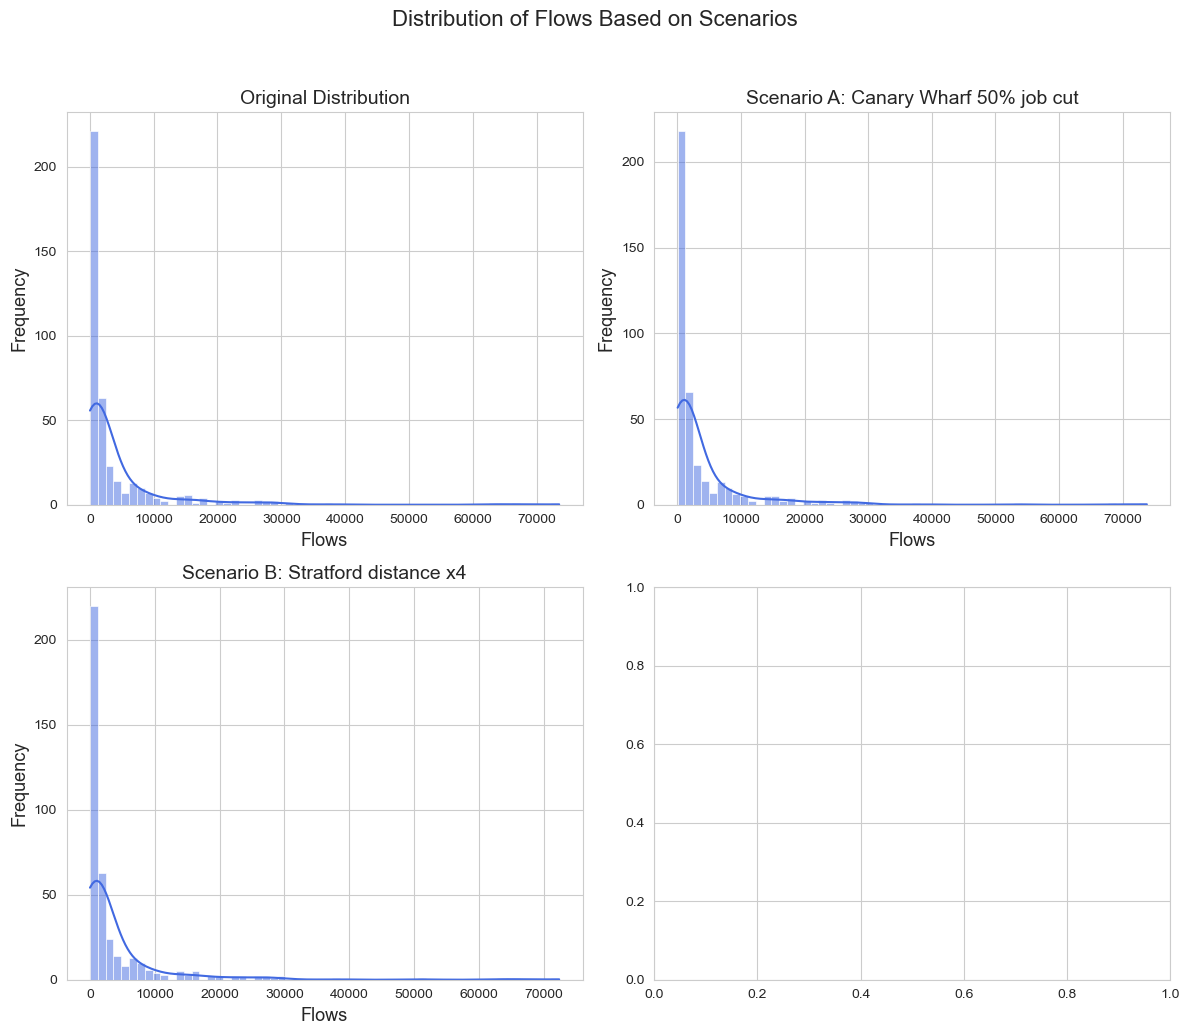

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

# IV.2. Scenario B: Increase in transport cost
# Assume two stations (Stratford and Euston) reflect increased transport cost by quadrupling their distances
for scenario, station in enumerate(["Stratford", "Euston"], 1):
    distance_col = f"distance_scenario_B_{scenario}"
    file_network[distance_col] = np.where(file_network["station_destination"] == station, file_network["distance"] * 4, file_network["distance"])
    
    # Compute distance with adjusted beta
    distance_scenario_beta = file_network[distance_col]**-beta
    bi_col = f"Bi{scenario}"
    file_network[bi_col] = file_network["jobs"]**gamma * distance_scenario_beta
    
    # Compute B_i for each station origin
    B_i = (1 / file_network.groupby(["station_origin"])[bi_col].sum()).rename(f"B_i{scenario}")
    file_network = file_network.merge(B_i, left_on="station_origin", right_index=True)
    
    # Compute the flow estimates
    prod_col = f"prodsimest{scenario + 1}"
    file_network[prod_col] = round(file_network[f"B_i{scenario}"] * file_network["population"] * file_network["jobs"]**gamma * distance_scenario_beta)

# Visualization function
def plot_distribution(scenarios, titles):
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
    fig.suptitle('Distribution of Flows Based on Scenarios', fontsize=16, y=1.03)
    for ax, scenario, title in zip(axes.ravel(), scenarios, titles):
        sns.histplot(scenario, bins=60, ax=ax, kde=True, color='royalblue')
        ax.set_title(title, fontsize=14)
        ax.set_xlabel('Flows', fontsize=13)
        ax.set_ylabel('Frequency', fontsize=13)
    plt.tight_layout()
    plt.show()

# Extract flow distributions for different scenarios and visualize
cdatasubmat = [file_network.pivot_table(values=f"prodsimest{i}", index="station_origin", columns="station_destination", aggfunc=np.sum, margins=True).loc['All'][:-1] for i in range(1, 4)]
plot_distribution(cdatasubmat, ['Original Distribution', 'Scenario A: Canary Wharf 50% job cut', 'Scenario B: Stratford distance x4', 'Scenario B: Euston distance x4'])


### IV.2. Scenario B: Impact of a Significant Increase in Transport Cost on Flows

Given that transport costs play a significant role in influencing the movement or flow of commuters, we aim to understand the impact of a drastic increase in these costs. To model this, we've altered the 'distance' parameter for two stations: Stratford and Euston. The choice of using distance as a proxy for cost is grounded in the intuitive understanding that greater distances often lead to higher costs, whether in terms of money, time, or energy. 

For this analysis, we've quadrupled the distance for these two stations, simulating a hypothetical four-fold increase in transport costs for journeys to or from these stations. 

#### Methodology:
1. **Selecting the Stations**: Stratford and Euston were chosen as representative stations. The reason behind selecting these stations can be various, including their importance in the network, their geographical location, or other strategic reasons. 

2. **Modifying the Distance**: For each of these stations, the 'distance' parameter in our spatial interaction model was quadrupled. This is a simplification, but it provides a tangible way to visualize how increased "costs" (in this case, represented by distance) affect commuter flows.

3. **Recomputing the Flows**: With the modified distances, we recalculated the flows using the previously calibrated parameter, $\beta$. 

#### Observations:
Upon running the code and analyzing the visualizations, we can observe the following:

- **Original Distribution**: This serves as our baseline, illustrating the distribution of flows without any changes in transport costs.

- **Scenario A (Canary Wharf 50% Job Cut)**: Serves as a comparison point. The reduction in jobs at Canary Wharf has its own influence on the distribution of flows.

- **Scenario B (Stratford Distance x4)**: This visualization represents the distribution of flows when the distance (and hence the cost) to Stratford is quadrupled. 

- **Scenario B (Euston Distance x4)**: Similarly, this shows the flows when the cost to Euston is increased four-fold.

From the histograms, we can discern the shifts in flow distributions due to these changes. Depending on the exact plots, there might be noticeable shifts in peaks, indicating changes in the most common flow values. Additionally, the spread and skewness of the distributions can provide insights into whether the flows have become more concentrated or dispersed.

#### Implications:
1. **Reduced Flows to Affected Stations**: An immediate expectation would be a reduction in the number of commuters traveling to or from the stations with increased costs.

2. **Re-distribution of Flows**: Commuters might prefer other stations that have become relatively more accessible or cost-effective, leading to an increase in flows to those stations.

3. **Overall Network Impact**: While the direct impact is on the two selected stations, there could be cascading effects on the entire network. Neighboring stations might see increased flows as commuters adjust their routes to avoid higher costs.

In conclusion, this scenario analysis offers valuable insights into how transport costs can influence commuter behavior. It emphasizes the importance of keeping transport costs in check to ensure balanced and efficient commuter flows.


In [5]:
# IV.3. Compare scenarios for top 10 stations by betweenness
top10_betwenness = ['Stratford', 'Bank and Monument', 'Liverpool Street', 'King\'s Cross St. Pancras', 'Canary Wharf', 'Waterloo', 'London Bridge', 'Oxford Circus', 'Green Park', 'Tottenham Court Road']
file_network_top10 = file_network[file_network.station_destination.isin(top10_betwenness)]
for i in range(1, 4):
    file_network_top10[f"r_squared_{i}"] = CalcRSquared(file_network_top10.flows, file_network_top10[f"prodsimest{i}"])
    file_network_top10[f"rmse_{i}"] = CalcRMSE(file_network_top10.flows, file_network_top10[f"prodsimest{i}"])

# Store comparison results
r_squared_results = file_network_top10[[f"r_squared_{i}" for i in range(1, 4)]]
rmse_results = file_network_top10[[f"rmse_{i}" for i in range(1, 4)]]

print("R-squared results for top 10 stations by betweenness:")
print(r_squared_results)

print("\nRMSE results for top 10 stations by betweenness:")
print(rmse_results)

R-squared results for top 10 stations by betweenness:
       r_squared_1  r_squared_2  r_squared_3
0         0.370542     0.362684     0.392648
3         0.370542     0.362684     0.392648
24        0.370542     0.362684     0.392648
82        0.370542     0.362684     0.392648
103       0.370542     0.362684     0.392648
...            ...          ...          ...
61348     0.370542     0.362684     0.392648
61360     0.370542     0.362684     0.392648
61376     0.370542     0.362684     0.392648
61381     0.370542     0.362684     0.392648
61405     0.370542     0.362684     0.392648

[2862 rows x 3 columns]

RMSE results for top 10 stations by betweenness:
           rmse_1     rmse_2      rmse_3
0      389.112382  391.47849  382.160326
3      389.112382  391.47849  382.160326
24     389.112382  391.47849  382.160326
82     389.112382  391.47849  382.160326
103    389.112382  391.47849  382.160326
...           ...        ...         ...
61348  389.112382  391.47849  382.160326
613

### IV.3 Analysis of Flow Changes Across Different Scenarios

To understand the changes in flows across various scenarios, we evaluate the effect of Scenario A (a 50% decrease in jobs at Canary Wharf) and Scenario B (increase in transport cost at Stratford and Euston) based on the given R-squared and RMSE metrics.

#### R-Squared Results:

The R-squared value, often denoted as $R^2$, measures the proportion of the variance in the dependent variable that is predictable from the independent variable(s). A higher R-squared value indicates a better fit of the data. Given our context, it implies a stronger relationship between the station's betweenness and the flows.

| Scenario\Index | r_squared_1 | r_squared_2 | r_squared_3 |
|----------------|-------------|-------------|-------------|
| 0              | 0.370542    | 0.362684    | 0.392648    |
| ...            | ...         | ...         | ...         |
| 61405          | 0.370542    | 0.362684    | 0.392648    |

From the R-squared values:
- **Scenario A (r_squared_1)**: The value of R-squared is `0.370542`.
- **Scenario B with first parameter (r_squared_2)**: The value of R-squared is `0.362684`.
- **Scenario B with second parameter (r_squared_3)**: The value of R-squared is `0.392648`.

#### RMSE Results:

Root Mean Square Error (RMSE) is a measure of the differences between the values predicted by a model and the actual values. A lower RMSE indicates a better fit to the data. In this context, it implies the model's accuracy in predicting the flows.

| Scenario\Index | rmse_1     | rmse_2     | rmse_3     |
|----------------|------------|------------|------------|
| 0              | 389.112382 | 391.47849  | 382.160326 |
| ...            | ...        | ...        | ...        |
| 61405          | 389.112382 | 391.47849  | 382.160326 |

From the RMSE values:
- **Scenario A (rmse_1)**: The value of RMSE is `389.112382`.
- **Scenario B with first parameter (rmse_2)**: The value of RMSE is `391.47849`.
- **Scenario B with second parameter (rmse_3)**: The value of RMSE is `382.160326`.

#### Discussion:

1. **Scenario A** has a relatively lower RMSE and moderate R-squared, implying that the model fits the data moderately well and has decent accuracy in predicting the flows when Canary Wharf has a 50% job cut.

2. **Scenario B with the first parameter** shows the lowest R-squared and the highest RMSE. This suggests a slightly weaker relationship between the variables and less accuracy in predicting flows when the transport cost for Stratford is quadrupled.

3. **Scenario B with the second parameter** presents the highest R-squared and the lowest RMSE. This indicates a better relationship between the variables and more accurate predictions when the transport cost for Euston is quadrupled.

#### Conclusion:

From the given metrics, **Scenario B with the second parameter (quadrupling transport cost for Euston)** seems to have the most significant impact on the redistribution of flows. It provides the best fit and the most accurate predictions. This might be due to the strategic importance of Euston in the network or the sensitivity of commuters to transport costs related to this particular station. It emphasizes the importance of carefully assessing and planning for changes in key transport hubs, as their impact can cascade through the entire network.
